In [1]:
from splinter import Browser
from bs4 import BeautifulSoup
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler

In [3]:
# Setup splinter
executable_path = {'executable_path': ChromeDriverManager().install()}
browser = Browser('chrome', **executable_path, headless=False)



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [C:\Users\glori\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


In [4]:
#Page URL
url = 'https://www.trulia.com/for_sale/36.63199,38.40726,-78.77798,-76.20855_xy/9_zm/'
browser.visit(url)

In [5]:
housePrices = []
houseRegion = []
houseSqrFt = []
houseBath = []
houseBed = []

for x in range(1, 20):
    print(f'Processing Page {x} - Initialize', end='\r')
    html = browser.html
    soup = BeautifulSoup(html, 'html.parser')
    
     #Data scrape from html
    prices = soup.find_all('div', {'data-testid' : "property-price"})
    beds = soup.find_all('div', {'data-testid' : "property-beds"})
    baths = soup.find_all('div', {'data-testid' : "property-baths"})
    sqrFt = soup.find_all('div', {'data-testid' : "property-floorSpace"})
    region = soup.find_all('div', {'data-testid' : "property-region"})
    print(f'Processing Page {x} - Data Scrape', end='\r')
    
#Add scraped data to lists
    for i, price in enumerate(prices):        
        housePrices.append(price.text)
        houseBed.append(beds[i].text[0])
        houseBath.append(baths[i].text[0])
        houseSqrFt.append(sqrFt[i].text.split()[0])
        houseRegion.append(region[i].text)
    print(f'Processing Page {x} - List append', end='\r')
   
    
#Next Page button
    browser.find_by_xpath('//*[@id="resultsColumn"]/nav/ul/li[8]/a/div/svg')
    print(f'Processing Page {x} - Next Page', end='\r')


In [6]:
# Initialize Data Frame
house_df = pd.DataFrame(
    {
        'Prices': housePrices,
        'Beds': houseBed,
        'Baths': houseBath,
        'SquareFt': houseSqrFt,
        'Loc': houseRegion
    }

)

In [7]:
#Data Conversion

try: 
    house_df.SquareFt = house_df.SquareFt.str.replace(',', '').astype(int)
except:
    print('Sqrft Data already converted.')
try:
    house_df.Beds = house_df.Beds.astype(int)
except:
    print('Bed Data already converted.')
try:
    house_df.Bath = house_df.Bath.astype(int)
except:
    print('Bath Data already converted.')

try:
    house_df.Prices = house_df.Prices.replace('[\$,]', '', regex=True).astype(float)
except:
    print('Price Data already Converted.')

Bath Data already converted.


In [8]:
house_df.dtypes

Prices      float64
Beds          int32
Baths        object
SquareFt      int32
Loc          object
dtype: object

In [9]:
features = ['Prices', 'Beds', 'Baths', 'SquareFt']

In [10]:
x = house_df.loc[:, features].values

y = house_df.loc[:,['Loc']].values

x = StandardScaler().fit_transform(x)

In [11]:
house_df

,Prices,Beds,Baths,SquareFt,Loc
0,379000.0,4,3,1940,"Charlottesville, VA"
1,259950.0,4,2,1756,"Chesterfield, VA"
2,299750.0,4,2,1750,"South Norfolk, Chesapeake, VA"
3,209000.0,3,2,1248,"North Chesterfield, VA"
4,280000.0,4,3,2080,"Chesterfield, VA"
...,...,...,...,...,...
565,390000.0,3,2,2466,"Charlottesville, VA"
566,270000.0,3,2,1067,"Fredericksburg, VA"
567,375000.0,3,2,1569,"Suffolk, VA"
568,315000.0,3,2,1922,"Glen Allen, VA"


In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(x)

principal_df = pd.DataFrame(
    data = principalComponents,
    columns = ['pc1', 'pc2']
    
)

In [13]:
finalDf = pd.concat(
    [principal_df, house_df[['Loc']]], axis = 1
)

In [14]:
finalDf

,pc1,pc2,Loc
0,0.528334,-0.440219,"Charlottesville, VA"
1,-0.971587,-0.831563,"Chesterfield, VA"
2,-0.808673,-0.633630,"South Norfolk, Chesapeake, VA"
3,-2.405341,-0.036344,"North Chesterfield, VA"
4,0.235224,-0.882326,"Chesterfield, VA"
...,...,...,...
565,-0.548064,1.363983,"Charlottesville, VA"
566,-2.309670,0.198014,"Fredericksburg, VA"
567,-1.415642,0.928188,"Suffolk, VA"
568,-1.352889,0.767950,"Glen Allen, VA"


In [23]:
import matplotlib.pyplot as plt
import matplotlib

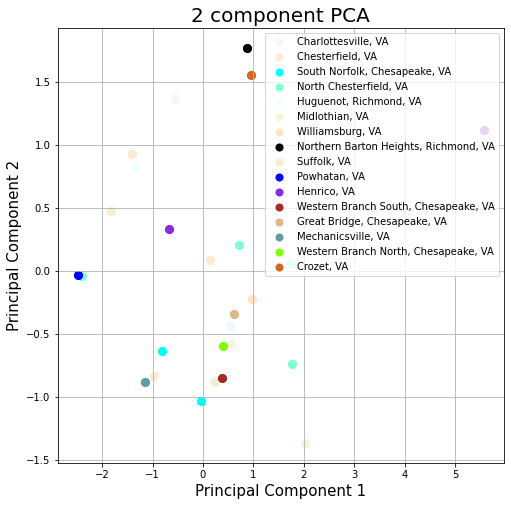

In [24]:
# Additon
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(pd.unique(house_df.Loc.values))
colors = list(matplotlib.colors.cnames.values())[0:16]
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Loc'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [21]:
list(pd.unique(house_df.Loc.values))

['Charlottesville, VA',
 'Chesterfield, VA',
 'South Norfolk, Chesapeake, VA',
 'North Chesterfield, VA',
 'Huguenot, Richmond, VA',
 'Midlothian, VA',
 'Williamsburg, VA',
 'Northern Barton Heights, Richmond, VA',
 'Suffolk, VA',
 'Powhatan, VA',
 'Henrico, VA',
 'Western Branch South, Chesapeake, VA',
 'Great Bridge, Chesapeake, VA',
 'Mechanicsville, VA',
 'Western Branch North, Chesapeake, VA',
 'Crozet, VA',
 'Fredericksburg, VA',
 'Glen Allen, VA']

In [22]:
targets = list(pd.unique(house_df.Loc.values))
colors = ['r']*15
list(zip(targets,colors))

[('Charlottesville, VA', 'r'),
 ('Chesterfield, VA', 'r'),
 ('South Norfolk, Chesapeake, VA', 'r'),
 ('North Chesterfield, VA', 'r'),
 ('Huguenot, Richmond, VA', 'r'),
 ('Midlothian, VA', 'r'),
 ('Williamsburg, VA', 'r'),
 ('Northern Barton Heights, Richmond, VA', 'r'),
 ('Suffolk, VA', 'r'),
 ('Powhatan, VA', 'r'),
 ('Henrico, VA', 'r'),
 ('Western Branch South, Chesapeake, VA', 'r'),
 ('Great Bridge, Chesapeake, VA', 'r'),
 ('Mechanicsville, VA', 'r'),
 ('Western Branch North, Chesapeake, VA', 'r')]

In [25]:
list(matplotlib.colors.cnames.values())[0:16]

['#F0F8FF',
 '#FAEBD7',
 '#00FFFF',
 '#7FFFD4',
 '#F0FFFF',
 '#F5F5DC',
 '#FFE4C4',
 '#000000',
 '#FFEBCD',
 '#0000FF',
 '#8A2BE2',
 '#A52A2A',
 '#DEB887',
 '#5F9EA0',
 '#7FFF00',
 '#D2691E']